In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
tariffs = pd.read_parquet('../data/tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

In [4]:
%run 'functions.py'

In [4]:
error_test_smol = []
error_test_big = []
error_2013 = []
frac_PC = []
# what subset of the population
# what training size

In [8]:
#looking at consumption values for 2012
# plt.plot(df2012['kWh/hh'].values[:120]);

In [9]:
#now we want to preprocess the data, I want a function that extracts, 
#for each the high, low, and average temperature for each day

#I also want to do pca on the 24 hour energy consumption, extract the first 4-5
#compoenents or so and then predict these with the month and the day of the week

#let's try the mean

df_avg_temp_2012 = pd.Series(df2012.groupby(['date'])['temp'].mean(), name="mean temp")
df_min_temp_2012 = pd.Series(df2012.groupby(['date'])['temp'].min(), name="min temp")
df_max_temp_2012 = pd.Series(df2012.groupby(['date'])['temp'].max(), name="max temp")

df_day_of_week_2012 = df2012.groupby(['date'])['day_of_week'].max()
df_month_2012 = df2012.groupby(['date'])['month'].max()

df_2012_processed = pd.concat([df_avg_temp_2012, df_min_temp_2012, df_max_temp_2012, 
                               df_day_of_week_2012, df_month_2012], axis=1)



df_avg_temp_2013 = pd.Series(df2013.groupby(['date'])['temp'].mean(), name="mean temp")
df_min_temp_2013 = pd.Series(df2013.groupby(['date'])['temp'].min(), name="min temp")
df_max_temp_2013 = pd.Series(df2013.groupby(['date'])['temp'].max(), name="max temp")
df_day_of_week_2013 = df2013.groupby(['date'])['day_of_week'].max()
df_month_2013 = df2013.groupby(['date'])['month'].max()

df_2013_processed = pd.concat([df_avg_temp_2013, df_min_temp_2013, df_max_temp_2013,
                               df_day_of_week_2013, df_month_2013], axis=1)

df_2013_processed.head()

,mean temp,min temp,max temp,day_of_week,month
date,,,,,
2013-07-01,15.433333,11.40,19.47,0,7
2013-07-02,14.662083,9.75,19.54,1,7
2013-07-03,16.400417,12.60,19.94,2,7
2013-07-04,16.989583,10.00,23.28,3,7
2013-07-05,17.295000,10.80,23.24,4,7


In [10]:
# how many PCs to keep
n=1

In [11]:
#what are the ys here:

y2012 = df2012['kWh/hh'].values.reshape((-1,24))

# from sklearn.decomposition import PCA

# pca = PCA(n_components = 4)

#let's do PCA by hand:

u, s, vh = np.linalg.svd(y2012.T.dot(y2012))

#extract the first 5 principal components:

prin_comp = vh[:n,:]

#project the y data down:


# matrix of 184*4 (PCs)
y_red_2012 = y2012.dot(prin_comp.T)
# all the temp, etc data as a matrix
X_2012 = df_2012_processed.values

In [12]:
# frac_PC.append((s[:n][-1])/s[0])

In [13]:
# plt.plot(s[:4], '-o')
# plt.title('Singular values for matrix of days of 2012 by hour level data')
# plt.savefig('../figs/SVs_random_forrest.png');

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RF

from sklearn.model_selection import GridSearchCV


# X_train, X_test, y_train, y_test = train_test_split(X_2012, y_red_2012, test_size=.2, random_state=42)
X_train = X_2012
y_train = y_red_2012

In [15]:
rf_reg = RF(max_depth=10)
np.random.seed(42)
rf_reg.fit(X_train, y_train)

# predit
# y_test_red_pred = rf_reg.predict(X_test)

RandomForestRegressor(max_depth=10)

In [16]:
# plt.figure()
# plt.plot(y_test[:, 0],label = 'real values')
# plt.plot(y_test_red_pred[:, 0],label = 'predicted values')
# plt.legend()
# plt.show()

In [18]:
# y_test_red_pred = y_test_red_pred.reshape(-1,1)

In [19]:
# y_test_pred = prin_comp.T.dot(y_test_red_pred.T).T.flatten()
# y_test_big = prin_comp.T.dot(y_test.T).T.flatten()

In [20]:
# round(((y_test[:, 0] - y_test_pred[:, 0])/y_test[:, 0]).mean()*100, 2)

In [21]:
# print(round(((y_test.flatten() - y_test_red_pred.flatten())/y_test.flatten()).mean()*100, 2))

In [20]:
# print(round(((y_test_big - y_test_pred)/y_test_big).mean()*100, 2))

In [21]:
# alright, can we optimize the parameters of the regressor

# param_grid = {'n_estimators':[70+5*i for i in range(10)],'max_depth':[4+9*i for i in range(10)]}

# search = GridSearchCV(rf_reg,param_grid,cv = 5)

# search.fit(X_train, y_train)

In [22]:
# search.best_params_

In [23]:
# best_est = search.best_estimator_

In [22]:
#let's predict the values for 2013

X_2013 = df_2013_processed.values
#dim = 184*4
y_2013_red_predict = rf_reg.predict(X_2013)

In [23]:
y_2013_red_predict = y_2013_red_predict.reshape(-1,1)

In [57]:
365*48

17520

In [112]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor



def add_date_column(dataframe):
    dates = pd.to_datetime(dataframe['DT']).dt.date
    dataframe['date'] = dates
    
def extract_mean_temps(df):
    return df.groupby(['date'])['temp'].mean().values

def extract_dow(df):
    return (df.groupby(['date'])['day_of_week'].max().values <5).astype(int)
    

def extract_month(df):
    #maybe this is bad since we're only training on a subset of these?
    v1 =  (df.groupby(['date'])['month'].max().values <=9)
    
    v2 = (df.groupby(['date'])['month'].max().values >4)
    
    v3 = np.logical_and(v1,v2)
    
    return v3.astype(int)
    

def create_dataset_2012(option, month):
    assert option in ['aff', 'comf', 'adv'], 'please select either aff, comf, or adv'
    if option == 'aff':
        df = pd.read_csv('~/Downloads/control data/affluent_2012.csv')
        df_t = pd.read_csv('~/Downloads/treatment data/affluent_2012_treatment.csv')
        
    elif option == 'comf':
        df = pd.read_csv('~/Downloads/control data/comfortable_2012.csv')
        df_t = pd.read_csv('~/Downloads/treatment data/comfortable_2012_treatment.csv')
        
    elif option == 'adv':
        df = pd.read_csv('~/Downloads/control data/adversity_2012.csv')
        df_t = pd.read_csv('~/Downloads/treatment data/adversity_2012_treatment.csv')
    
    #construct the dataset
    df['DT'] = df['DT'].astype('datetime64[ns]')
    df_t['DT'] = df_t['DT'].astype('datetime64[ns]')
    df = df.loc[df['DT'].dt.month == month]
    df_t = df_t.loc[df_t['DT'].dt.month == month]
    
    #first let's construct the desired outputs (I'm not going to use PCA right now, could change)
    y = df_t['kWh/hh'].values.reshape((-1,24)) #reshape for each day
    
    #use np.c_ to concatenate easily I think should work
    
    input_energy_vals = df['kWh/hh'].values.reshape((-1,24))
    
    pca = PCA(n_components =2)
    pca.fit(input_energy_vals)
    input_energy_vals = pca.transform(input_energy_vals)
    
    add_date_column(df)
    t1 = extract_dow(df)
    t2 = extract_mean_temps(df)
    t3 = extract_month(df)
    input_data = np.c_[t1,t2,t3]
    
    X = np.c_[input_data, input_energy_vals]

    return X, y, pca

def train_estimator(X,y,test_size = 0):
    #let's try to use another random forest with grid_search cv
    #but we'll limit the complexity with max_depth
    
    #first things first, we're going to split up our training data
    np.random.rand(42) #for consistency
    
#     Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size = test_size)
    
    #now let's initialize the model and train
    
    reg_model = RandomForestRegressor(n_estimators=100, max_depth=5)
    
    
    #don't do the following, parameters already optimized
    
#     param_grid = {'n_estimators':[80+10*i for i in range(5)],
#                  'max_depth': [3+2*i for i in range(8)]}
    
#     search = GridSearchCV(rf_reg,param_grid,cv = 4)
    
#     #fit the model
#     search.fit(X,y)
    
#     print('Best Params ',search.best_params_)
    
#     reg_model = search.best_estimator_
    
#     plot to see how well this works on the test set.
    
#     ytest_pred = reg_model.predict(Xtest).flatten()
    
#     plt.figure()
#     plt.plot(ytest.flatten(),label='true values')
#     plt.plot(ytest_pred, label = 'predicted values')
#     plt.legend()
#     plt.show()
#     assert False

    reg_model.fit(X,y)
    
    return reg_model
    

def predict_2013(reg_model, pca, option, month):
    assert option in ['aff', 'comf', 'adv'], 'please select either aff, comf, or adv'
    
    #need to create the dataset using the 2013 control data:
    if option == 'aff':
        df = pd.read_csv('~/Downloads/control data/affluent_2013.csv')
        
    elif option == 'comf':
        df = pd.read_csv('~/Downloads/control data/comfortable_2013.csv')
        
    elif option == 'adv':
        df = pd.read_csv('~/Downloads/control data/adversity_2013.csv')
        
    df['DT'] = df['DT'].astype('datetime64[ns]')
    df = df.loc[df['DT'].dt.month == month]

    input_energy_vals = df['kWh/hh'].values.reshape((-1, 24))
    input_energy_vals = pca.transform(input_energy_vals)
    
    add_date_column(df)
    t1 = extract_dow(df)
    t2 = extract_mean_temps(df)
    t3 = extract_month(df)
    input_data = np.c_[t1, t2, t3]
    
    X = np.c_[input_data, input_energy_vals]
        
    y_pred_2013 = reg_model.predict(X)
    
    return y_pred_2013.flatten()

def make_predictions_2013(option, month):
    assert option in ['aff', 'comf', 'adv'], 'please select either aff, comf, or adv'
    
    #create dataset
    X, y, pca = create_dataset_2012(option, month)
    
    #train model on 2012 data
    reg_model = train_estimator(X, y)
    
    #make predictions
    y_pred = predict_2013(reg_model, pca, option, month)
    
    return y_pred

In [149]:
month=12

In [150]:
# import the data
# df2012 = pd.read_csv('~/Downloads/treatment data/adversity_2012_treatment.csv')
df2013_adv = pd.read_csv('~/Downloads/treatment data/adversity_2013_treatment.csv')
df2013_com = pd.read_csv('~/Downloads/treatment data/comfortable_2013_treatment.csv')
df2013_aff = pd.read_csv('~/Downloads/treatment data/affluent_2013_treatment.csv')
#looks like we might need to add an index
# df2012['date'] = pd.to_datetime(df2012['DT']).dt.date
# df2013['date'] = pd.to_datetime(df2013['DT']).dt.date

df2013_adv['DT'] = df2013_adv['DT'].astype('datetime64[ns]')
df2013_com['DT'] = df2013_com['DT'].astype('datetime64[ns]')
df2013_aff['DT'] = df2013_aff['DT'].astype('datetime64[ns]')

df2013_adv = df2013_adv.loc[df2013_adv['DT'].dt.month == month]
df2013_com = df2013_com.loc[df2013_com['DT'].dt.month == month]
df2013_aff = df2013_aff.loc[df2013_aff['DT'].dt.month == month]

In [151]:
# reconstruct the 24 hour values
# prin_comp is of dimension 4*24
# (24*4 * 4*184).T

# y_2013_predictions = prin_comp.T.dot(y_2013_red_predict.T).T.flatten()
df2013_adv['pred'] = make_predictions_2013('adv', month)
df2013_com['pred'] = make_predictions_2013('comf', month)
df2013_aff['pred'] = make_predictions_2013('aff', month)

In [84]:
df2012_com = pd.read_csv('~/Downloads/control data/comfortable_2013.csv')
df2012_adv = pd.read_csv('~/Downloads/control data/adversity_2013.csv')
df2012_aff = pd.read_csv('~/Downloads/control data/affluent_2013.csv')

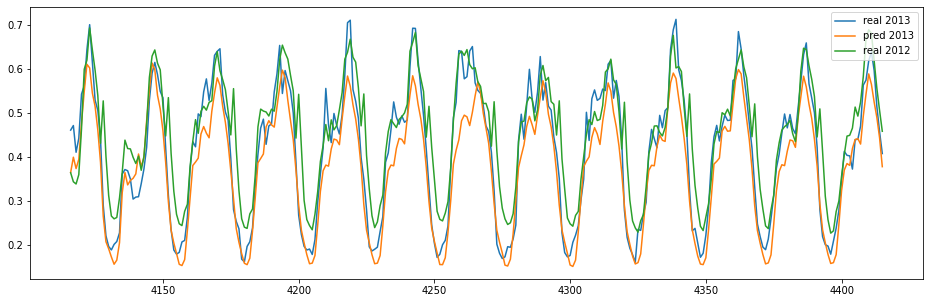

In [70]:
# adversity 
plt.figure(figsize=(16, 5))
t=-300
plt.plot(df2013_adv['kWh/hh'][t:], label='real 2013')
plt.plot(df2013_adv['pred'][t:], label='pred 2013')
plt.plot(df2012_adv['kWh/hh'][t:], label='real 2012')
plt.legend(loc=1)
plt.show()

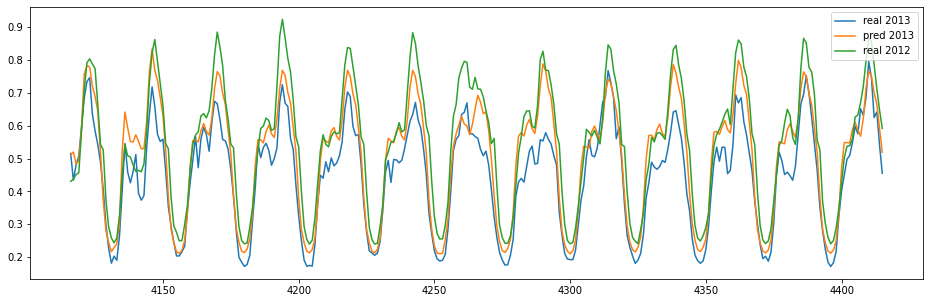

In [67]:
# comfortable 
plt.figure(figsize=(16, 5))
t=-300
plt.plot(df2013_com['kWh/hh'][t:], label='real 2013')
plt.plot(df2013_com['pred'][t:], label='pred 2013')
plt.plot(df2012_com['kWh/hh'][t:], label='real 2012')
plt.legend(loc=1)
plt.show()

In [73]:
((df2013_aff['kWh/hh'] - df2012_aff['kWh/hh'])/df2013_aff['kWh/hh']).mean()

-0.18763948358177454

In [75]:
((df2013_com['kWh/hh'] - df2012_com['kWh/hh'])/df2013_com['kWh/hh']).mean()

-0.19095219415822537

In [74]:
((df2013_adv['kWh/hh'] - df2012_adv['kWh/hh'])/df2013_adv['kWh/hh']).mean()

-0.11430977406026678

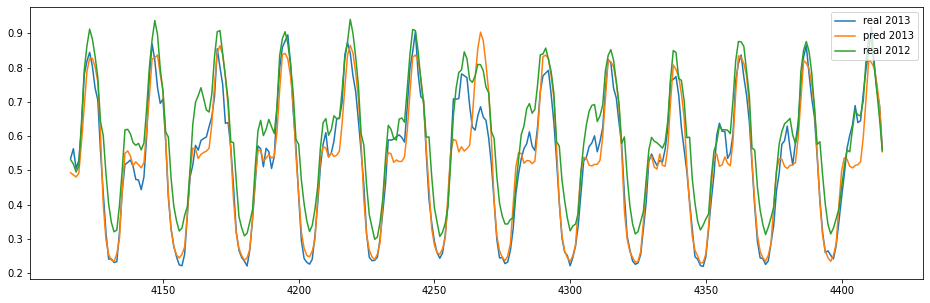

In [71]:
# affluent 
plt.figure(figsize=(16, 5))
t=-300
plt.plot(df2013_aff['kWh/hh'][t:], label='real 2013')
plt.plot(df2013_aff['pred'][t:], label='pred 2013')
plt.plot(df2012_aff['kWh/hh'][t:], label='real 2012')
plt.legend(loc=1)
plt.show()

In [60]:
df2012_com['date'] = pd.to_datetime(df2012_com['DT']).dt.date

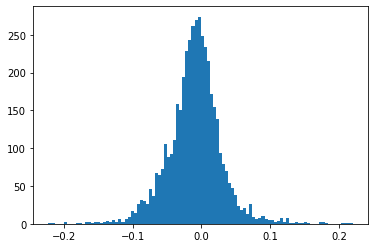

In [53]:
plt.hist(df2013_aff['kWh/hh'] - df2013_aff['pred'], bins=100);

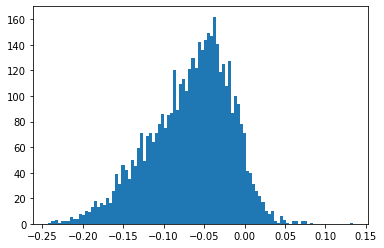

In [54]:
plt.hist(df2013_com['kWh/hh'] - df2013_com['pred'], bins=100);

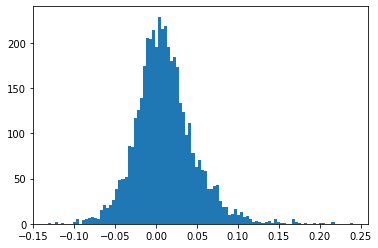

In [55]:
plt.hist(df2013_adv['kWh/hh'] - df2013_adv['pred'], bins=100);

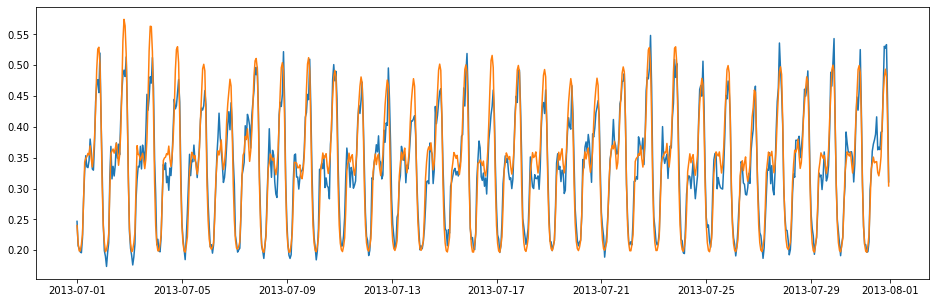

In [47]:
# affluent
plt.figure(figsize=(16, 5))
t=0
plt.plot(df2013_aff['DT'][t:], df2013_aff['kWh/hh'][t:], label='real')
plt.plot(df2013_aff['DT'][t:], df2013_aff['pred'][t:], label='pred')
# plt.plot(df2013_aff['DT'], df2013_aff['kWh/hh'] - df2013_aff['pred'])
# plt.legend()
plt.show()

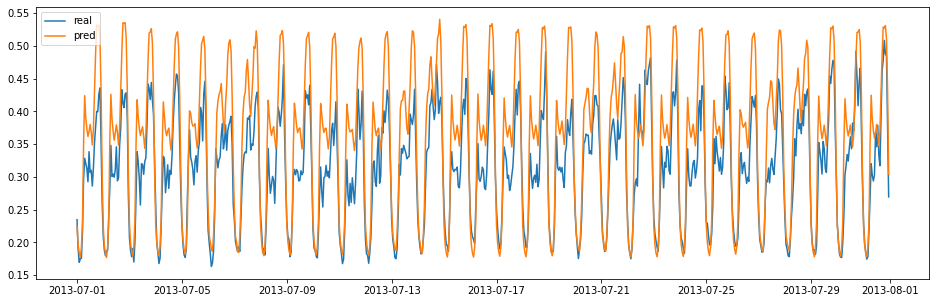

In [45]:
# comfortable 
plt.figure(figsize=(16, 5))
t=0
plt.plot(df2013_com['DT'][t:], df2013_com['kWh/hh'][t:], label='real')
plt.plot(df2013_com['DT'][t:], df2013_com['pred'][t:], label='pred')
# plt.plot(df2013_com['DT'], df2013_com['kWh/hh'] - df2013_com['pred'])
plt.legend()
plt.show()

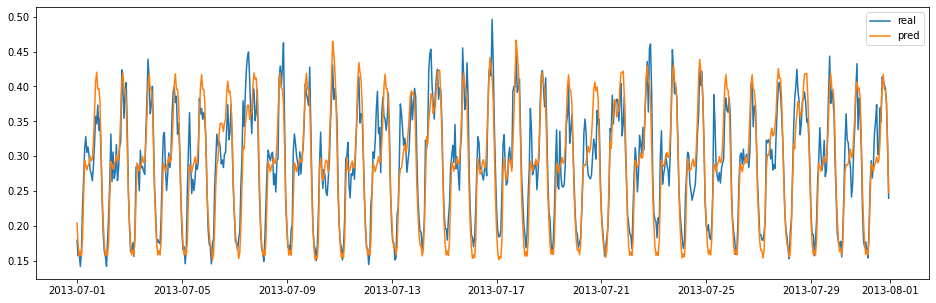

In [46]:
# adversity
plt.figure(figsize=(16, 5))
t=0
plt.plot(df2013_adv['DT'][t:], df2013_adv['kWh/hh'][t:], label='real')
plt.plot(df2013_adv['DT'][t:], df2013_adv['pred'][t:], label='pred')
# plt.plot(df2013_adv['DT'], df2013_adv['kWh/hh'] - df2013_adv['pred'])
plt.legend()
plt.show()

In [24]:
def get_me_mpe(df, group):
    cut = df.loc[df['DT'].isin(group)]
    me = (cut['kWh/hh'] - cut['pred']).mean()
    mpe = ((cut['kWh/hh'] - cut['pred'])/cut['kWh/hh']).mean()*100
    return me, mpe

In [152]:
ME_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])

In [153]:
ME_consumption.loc['Affluent', 'Low'], MPE_consumption.loc['Affluent', 'Low'] = get_me_mpe(df2013_aff, lows)

ME_consumption.loc['Affluent', 'Normal'], MPE_consumption.loc['Affluent', 'Normal'] = get_me_mpe(df2013_aff, normals)

ME_consumption.loc['Affluent', 'High'], MPE_consumption.loc['Affluent', 'High'] = get_me_mpe(df2013_aff, highs)

ME_consumption.loc['Affluent', 'Overall'], MPE_consumption.loc['Affluent', 'Overall'] = get_me_mpe(df2013_aff, df2013_aff['DT'])

ME_consumption.loc['Comfortable', 'Low'], MPE_consumption.loc['Comfortable', 'Low'] = get_me_mpe(df2013_com, lows)

ME_consumption.loc['Comfortable', 'Normal'], MPE_consumption.loc['Comfortable', 'Normal'] = get_me_mpe(df2013_com, normals)

ME_consumption.loc['Comfortable', 'High'], MPE_consumption.loc['Comfortable', 'High'] = get_me_mpe(df2013_com, highs)

ME_consumption.loc['Comfortable', 'Overall'], MPE_consumption.loc['Comfortable', 'Overall'] = get_me_mpe(df2013_com, df2013_com['DT'])

ME_consumption.loc['Adversity', 'Low'], MPE_consumption.loc['Adversity', 'Low'] = get_me_mpe(df2013_adv, lows)

ME_consumption.loc['Adversity', 'Normal'], MPE_consumption.loc['Adversity', 'Normal'] = get_me_mpe(df2013_adv, normals)

ME_consumption.loc['Adversity', 'High'], MPE_consumption.loc['Adversity', 'High'] = get_me_mpe(df2013_adv, highs)

ME_consumption.loc['Adversity', 'Overall'], MPE_consumption.loc['Adversity', 'Overall'] = get_me_mpe(df2013_adv, df2013_adv['DT'])

In [154]:
ME_consumption = ME_consumption.astype(float)
MPE_consumption = MPE_consumption.astype(float)

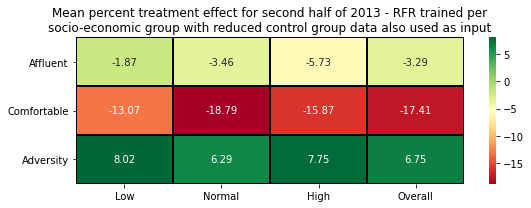

In [155]:
# trained on all of 2012
# month = 12
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean percent treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr_w_c.png')

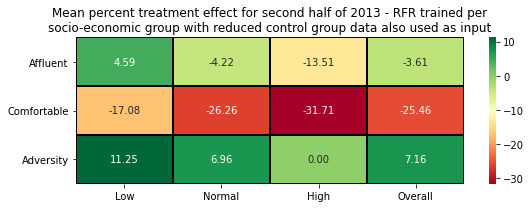

In [148]:
# trained on all of 2012
# month = 11
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean percent treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr_w_c.png')

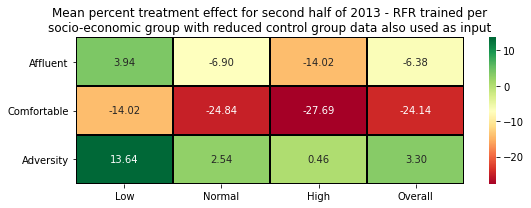

In [141]:
# trained on all of 2012
# month = 10
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean percent treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr_w_c.png')

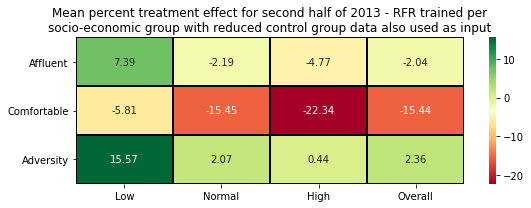

In [133]:
# trained on all of 2012
# month = 9
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean percent treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr_w_c.png')

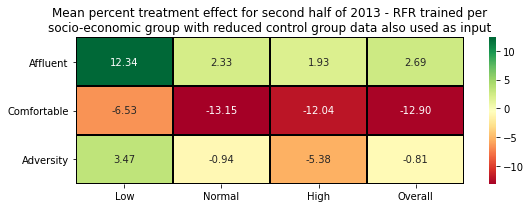

In [126]:
# trained on all of 2012
# month = 8
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean percent treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr_w_c.png')

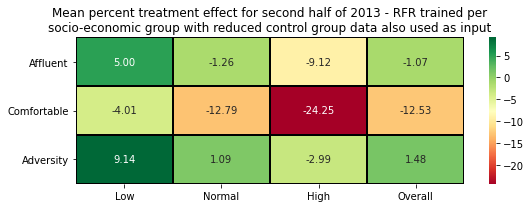

In [118]:
# trained on all of 2012
# month = 7
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean percent treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr_w_c.png')

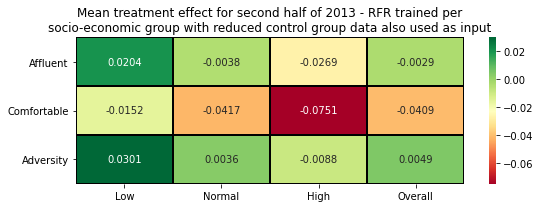

In [119]:
# trained on all of 2012
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(ME_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean treatment effect for second half of 2013 - RFR trained per'
             '\n'
             r'socio-economic group with reduced control group data also used as input')
plt.tight_layout()
# plt.savefig('../figs/ME_consumption_rfr_w_c.png')

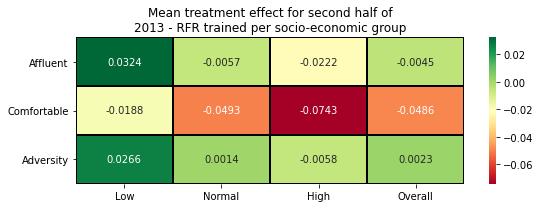

In [28]:
# trained on all of 2012
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(ME_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax);
ax.set_title(r'Mean treatment effect for second half of'
             '\n'
             r'2013 - RFR trained per socio-economic group')
plt.tight_layout()
# plt.savefig('../figs/ME_consumption_rfr.png')

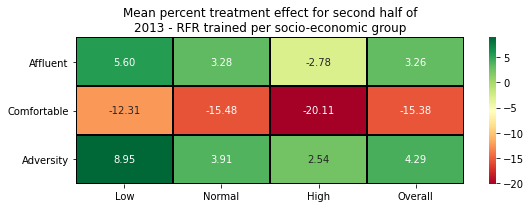

In [759]:
# trained on 80% of 2012
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean percent treatment effect for second half of'
             '\n'
             r'2013 - RFR trained per socio-economic group')
plt.tight_layout()
# plt.savefig('../figs/MPE_consumption_rfr.png')

In [525]:
# plt.figure()
# plt.plot(y_2013[400:500],label = "true values 2013")
# plt.plot(y_2013_predictions[400:500],label = 'predicted values 2013')
# plt.legend()
# plt.show()

In [526]:
error_2013.append(round(((y_2013 - y_2013_predictions)/y_2013).mean()*100, 2))

0.46

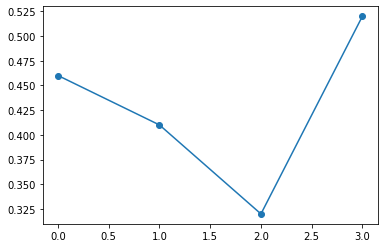

In [884]:
# plt.plot(error_test_smol)
plt.plot(error_test_big, '-o')
error_test_big[0]

3.63


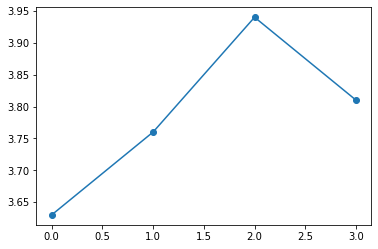

In [528]:
plt.plot(error_2013, '-o')
print(error_2013[0])

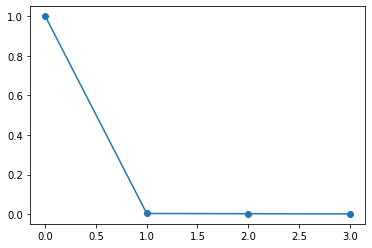

In [529]:
plt.plot(frac_PC, '-o')